In [48]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt


class GaussianArm(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def draw(self):
        return np.random.normal(self.mu, self.sigma)

    
class Agent(object):
    def __init__(self, k=10, epsilon=0.1, init_val=0, ucb=True):
        self.k = k
        self.values = [init_val]*k
        self.counts = [0]*k
        self.epsilon = epsilon
        self.ucb =ucb
        
    def choose_action(self):
        r = np.random.rand()
        
        if self.ucb == False:
            if r < self.epsilon:
                action = np.random.randint(10)
            else:
                action = np.argmax(self.values)
        else:
            tmp_val = [0]*self.k
            t = np.sum(self.counts)
            for i in xrange(self.k):
                tmp_val = self.values[i] + r * np.sqrt(abs(np.log(t+1e-6)/(self.counts[i]+1e-6)))
            
            action = np.argmax(self.values)
            
        return action
    
    def update_values(self, action, reward):
        self.counts[action] += 1
        n = float(self.counts[action])
        self.values[action] = (n-1)/n * self.values[action] + 1/n * reward
    

In [11]:
def gen_arms(K, mu_min, mu_max, sigma):
    ''' generate arms '''
    arms = []
    for i in xrange(K):
        mu = mu_min + np.random.rand() * (mu_max - mu_min)
        arm = GaussianArm(mu, sigma)
        arms.append(arm)
    
    mus = [round(arms[i].mu, 2) for i in xrange(K)]
    error = [round(arms[i].sigma, 2) for i in xrange(K)]
    plt.errorbar(range(1, K+1), mus, yerr=error, marker='o', color='white', ecolor='blue')
    plt.xlabel('Action')
    plt.ylabel('Reward Distributions')
    plt.title('An exemplary bandit problem from the %d-armed testbed' % K)
    plt.axis([0, K, mu_min-2*sigma, mu_max+2*sigma])
    plt.show()
    
    return arms



In [13]:
def compare_different_epsilons(K=10, mu_min=0, mu_max=0, sigma=1, T=10000, d=500):
    K = 10
    mu_min = mu_min
    mu_max = mu_max
    sigma = sigma
    arms = gen_arms(K, mu_min, mu_max, sigma)

    ''' test agents with different epsilons '''
    epsilons = [0.0, 0.05, 0.1, 0.2, 0.5, 1]
    def descriptions(e):
        text = 'ep=%.2f' % e
        if e == 1.0: 
            text += ' -- random guess'
        elif e == 0.0:
            text += ' -- greedy'
        return text

    xs = range(0, T, d)
    ys = []*len(epsilons)
    for i in xrange(len(epsilons)):
        e = epsilons[i]
        rewards = []
        agent = Agent(k=K, epsilon=e)
        for i in xrange(T):
            action = agent.choose_action()
            reward = arms[action].draw()
            agent.update_values(action, reward)
            rewards.append(reward)
            
        ys_e = []
        for x in xs:
            ys_e.append(np.sum(rewards[x-d:x])/float(d))
        ys.append(ys_e)

    series = [ descriptions(e) for e in epsilons]
    colors = ['red','blue','green','magenta','black','cyan']
    for i in xrange(len(epsilons)):
        plt.plot(xs, ys[i], label=series[i], color=colors[i])
    plt.xlabel('# of Iterations')
    plt.ylabel('Average Reward')
    plt.title('RL Agent Performace')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

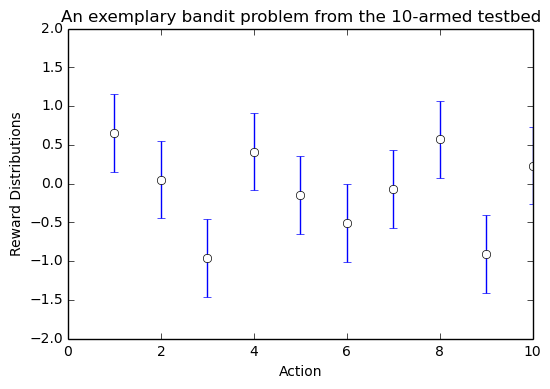

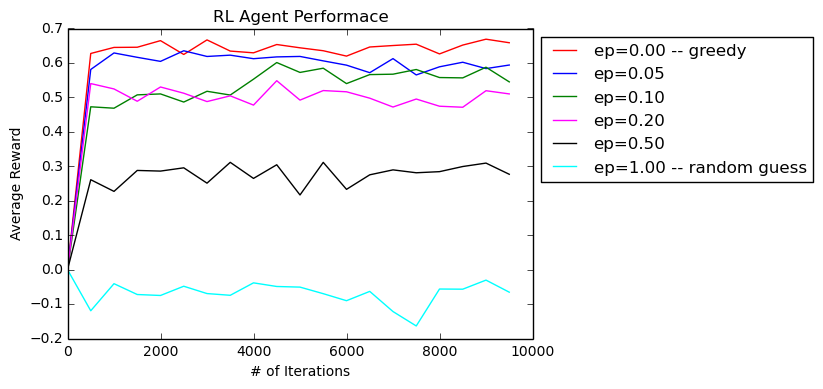

In [14]:
compare_different_epsilons(mu_min=-1, mu_max=1, sigma=0.5)

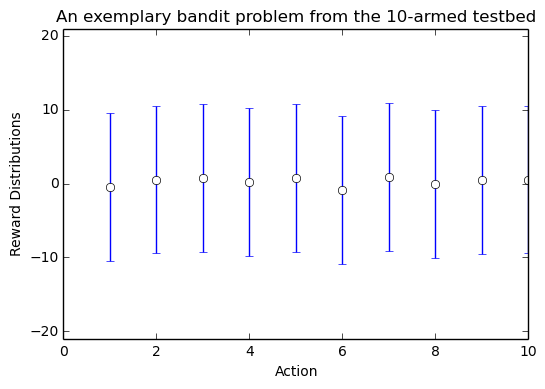

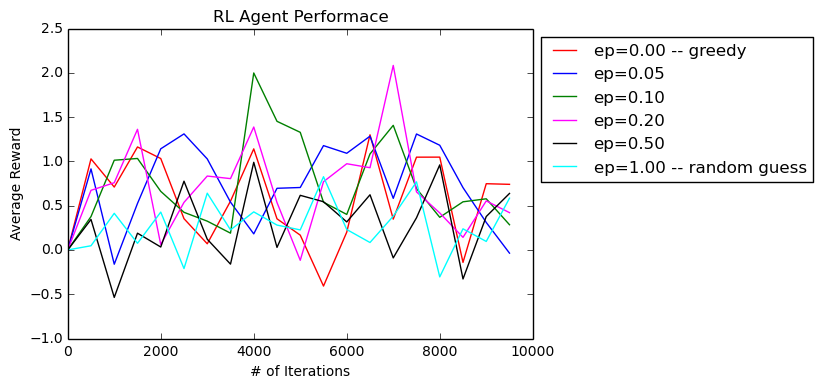

In [15]:
compare_different_epsilons(mu_min=-1, mu_max=1, sigma=10)

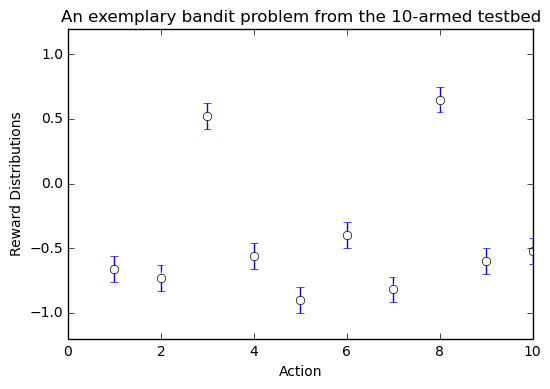

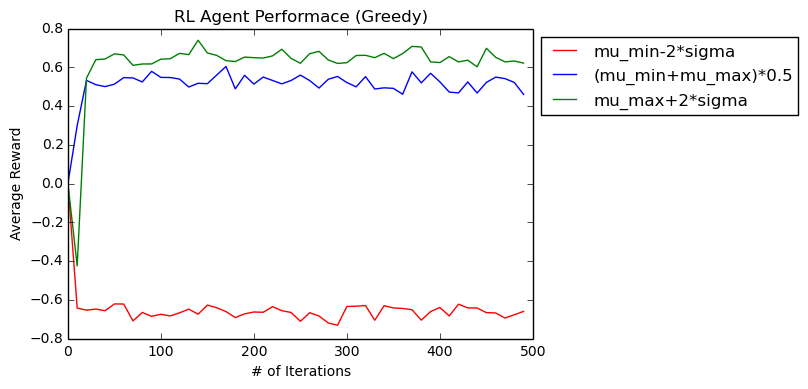

In [62]:
def compare_different_init_vals(K=10, mu_min=0, mu_max=0, sigma=1, T=10000, d=500):
    K = 10
    mu_min = mu_min
    mu_max = mu_max
    sigma = sigma
    arms = gen_arms(K, mu_min, mu_max, sigma)

    ''' test agents with different init_vals '''

    init_vals = [mu_min-2*sigma, (mu_min+mu_max)*0.5, mu_max+2*sigma]
    xs = range(0, T, d)
    ys = []*len(init_vals)
    for v in init_vals:
        rewards = []
        agent = Agent(k=K, epsilon=0, init_val=v)
        for i in xrange(T):
            action = agent.choose_action()
            reward = arms[action].draw()
            agent.update_values(action, reward)
            rewards.append(reward)
            
        ys_v = []
        for x in xs:
            ys_v.append(np.sum(rewards[x-d:x])/float(d))
        ys.append(ys_v)
    
    series = ['mu_min-2*sigma', '(mu_min+mu_max)*0.5', 'mu_max+2*sigma']
    colors = ['red','blue','green','magenta','black','cyan']
    for i in xrange(len(init_vals)):
        plt.plot(xs, ys[i], label=series[i], color=colors[i])
    plt.xlabel('# of Iterations')
    plt.ylabel('Average Reward')
    plt.title('RL Agent Performace (Greedy)')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

compare_different_init_vals(mu_min=-1, mu_max=1, sigma=0.1, T=500, d=10)

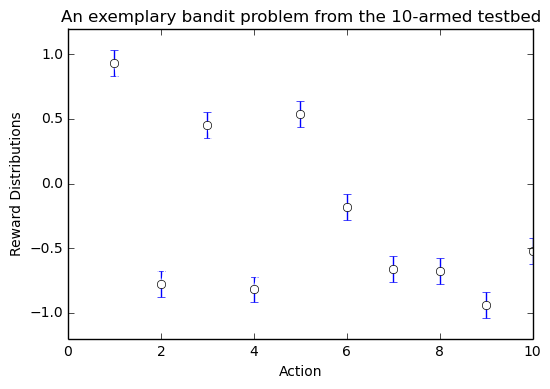

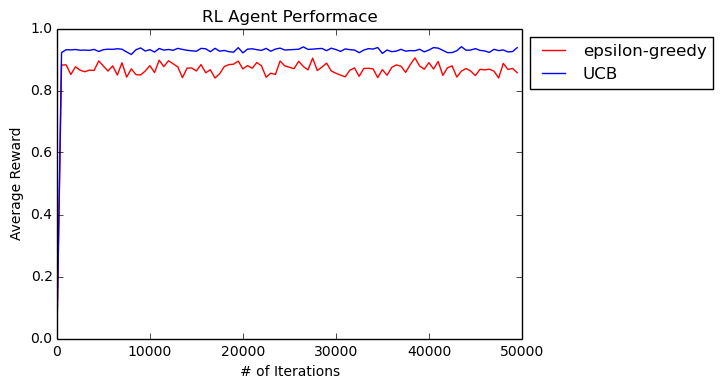

In [53]:
def try_ucb(K=10, mu_min=0, mu_max=0, sigma=1, T=10000, d=500):
    K = 10
    mu_min = mu_min
    mu_max = mu_max
    sigma = sigma
    arms = gen_arms(K, mu_min, mu_max, sigma)

    ''' test agents with different init_vals '''

    xs = range(0, T, d)
    ys = []*2
    
    ''' epsilon-greedy '''
    agent = Agent(k=K, epsilon=0.05, ucb=False)
    rewards = []
    for i in xrange(T):
        action = agent.choose_action()
        reward = arms[action].draw()
        agent.update_values(action, reward)
        rewards.append(reward)

    ys_ = []
    for x in xs:
        ys_.append(np.sum(rewards[x-d:x])/float(d))
    ys.append(ys_)
    
    
    ''' UCB (upper confidence bound) '''
    agent = Agent(k=K, epsilon=0.05, ucb=True)
    rewards = []
    for i in xrange(T):
        action = agent.choose_action()
        reward = arms[action].draw()
        agent.update_values(action, reward)
        rewards.append(reward)

    ys_ = []
    for x in xs:
        ys_.append(np.sum(rewards[x-d:x])/float(d))
    ys.append(ys_)   
    
    
    series = ['epsilon-greedy', 'UCB']
    colors = ['red','blue','green','magenta','black','cyan']
    for i in xrange(len(series)):
        plt.plot(xs, ys[i], label=series[i], color=colors[i])
    plt.xlabel('# of Iterations')
    plt.ylabel('Average Reward')
    plt.title('RL Agent Performace')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

try_ucb(mu_min=-1, mu_max=1, sigma=0.1, T=50000, d=500)